# Pytorch Introduction

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/m12sl/dl-hse-2020/blob/master/02-mechanics/pytorch%20train%20loop.ipynb)

В этой тетрадке мы напишем познакомимся с базовыми возможностями pytorch.

**Цели тетрадки**

1. Познакомиться с типами данных и арифметикой в pytorch.
1. Научиться пользоваться автоматическим дифференцированием.
1. Попробовать low-level и high-level API на нескольких задачах.



**План работы**

1. Познакомиться на примерах с pytorch API.
1. Научиться получать градиенты для переменных.
1. Реализовать линейную регрессию на pytorch.
1. Натренировать классификатор FashionMNIST с помощью high-level API.
1. Зафайнтюнить предобученную модель из пакета torchvision.


## Материалы по pytorch:

+ https://pytorch.org/resources/
+ https://pytorch.org/docs/stable/index.html
+ ходить по исходникам с помощью IDE
+ [Классная статья про pytorch internal](http://blog.ezyang.com/2019/05/pytorch-internals/)


## Важные модули:

- `autograd` -- функции для вычисления производных
- `nn`-- классы для слоев и моделей
- `nn.functional` -- функциональный API для некоторых операций
- `nn.init` -- различные варианты инциализации
- `optim` -- оптимизаторы
- `utils.data` -- API для работы с данными (Dataset & DataLoader)


**Дополнительные пакеты:**
- `torchvision` -- предобученные модели, преобразования картинок и датасеты
- `torchaudio` -- датасеты и полезные преобразования
- `torchtext` -- датасеты и полезные функции

In [2]:
# install requirements
! pip install torchviz torchvision

In [3]:
%matplotlib inline
from collections import defaultdict

from IPython.display import clear_output  # потребуется для перерисовки графиков
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchviz  # потребуется для отображения графов
from tqdm.auto import tqdm

## Основа вычислений: torch.Tensor


Это практически `numpy.ndarray` с некоторыми дополнительными возможностями.

Официальная документация: https://pytorch.org/docs/stable/tensors.html


**Важные поля:**
- `.device` -- `cuda` или `cpu`
- `.dtype` -- более строгие правила приведения типов, чем в numpy
- `.requires_grad` -- флаг говорит, должен ли автоград вычислять градиенты для этой переменной
- `.data` -- содержимое переменной
- `.grad` -- градиенты, сохраненные для этой переменной





In [4]:
# numpy world
x = np.arange(16).astype(np.float32).reshape(4, 4)

print("X :\n %s" % x)
print("add 5 :\n%s" % (x + 5))
print("X*X^T  :\n", np.dot(x, x.T))
print("mean over cols :\n%s" % (x.mean(axis=-1)))
print("cumsum of cols :\n%s" % (np.cumsum(x, axis=0)))

X :
 [[ 0.  1.  2.  3.]
 [ 4.  5.  6.  7.]
 [ 8.  9. 10. 11.]
 [12. 13. 14. 15.]]
add 5 :
[[ 5.  6.  7.  8.]
 [ 9. 10. 11. 12.]
 [13. 14. 15. 16.]
 [17. 18. 19. 20.]]
X*X^T  :
 [[ 14.  38.  62.  86.]
 [ 38. 126. 214. 302.]
 [ 62. 214. 366. 518.]
 [ 86. 302. 518. 734.]]
mean over cols :
[ 1.5  5.5  9.5 13.5]
cumsum of cols :
[[ 0.  1.  2.  3.]
 [ 4.  6.  8. 10.]
 [12. 15. 18. 21.]
 [24. 28. 32. 36.]]


In [5]:
# pytorch world
x = torch.arange(16).float().view(4, 4)

print("X :\n%s" % x)
print("add 5 :\n%s" % (x + 5))
print("X*X^T  :\n", torch.matmul(x, x.transpose(1, 0)))
print("mean over cols :\n", torch.mean(x, dim=-1))
print("cumsum of cols :\n", torch.cumsum(x, dim=0))

X :
tensor([[ 0.,  1.,  2.,  3.],
        [ 4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11.],
        [12., 13., 14., 15.]])
add 5 :
tensor([[ 5.,  6.,  7.,  8.],
        [ 9., 10., 11., 12.],
        [13., 14., 15., 16.],
        [17., 18., 19., 20.]])
X*X^T  :
 tensor([[ 14.,  38.,  62.,  86.],
        [ 38., 126., 214., 302.],
        [ 62., 214., 366., 518.],
        [ 86., 302., 518., 734.]])
mean over cols :
 tensor([ 1.5000,  5.5000,  9.5000, 13.5000])
cumsum of cols :
 tensor([[ 0.,  1.,  2.,  3.],
        [ 4.,  6.,  8., 10.],
        [12., 15., 18., 21.],
        [24., 28., 32., 36.]])


Numpy и Pytorch не требуют описания статического графа вычислений.
Результат получается сразу при выполнении.

Можно отлаживаться с помощью pdb/ipdb или просто print.

API несколько различается:

|        numpy        |      pytorch    |
|:-------             |         -------:|
| `x.reshape([1,2,8])`| `x.view(1,2,8)` |
| `x.sum(axis=-1)`    | `x.sum(dim=-1)` |
| `x.astype('int64')` | `x.type(torch.int64)` |


Легко конвертировать между собой:

```python
torch.from_numpy(npx) # -- вернет Tensor
tt.numpy() # -- вернет Numpy Array
```

Преобразовать тензор из одного числа в обычное питоновское число:
```python
torch.tensor([1]).item() # 1
```

## Вычислительный граф

Вычислительный граф строится по выражениям, в которых участвует `torch.tensor`.

Все вершины в графе можно разбить на два класса: Leaf (листовые) и Non-Leaf (не листовые) вершины. 

Если тензор не зависит от других, он является листовой вершиной.

Для оптимизации памяти, pytorch будет считать градиенты только для _листовых_ переменных с выставленным флагом `requires_grad=True`:

tensor([ -2.,  -6., -12., -20.], grad_fn=<MulBackward0>)


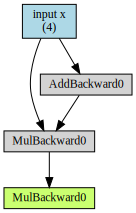

In [6]:
x = torch.tensor([1., 2., 3., 4.], requires_grad=True)  # leaf tensor
alpha = torch.tensor([-1.0, ]) # leaf, but without grads
y = x + 1  # not a leaf variable
z = x * y * alpha
print(z)


torchviz.make_dot(z, {"input x": x})

In [7]:
x = torch.tensor([1., 2., 3., 4.], requires_grad=True)  # leaf tensor
alpha = torch.tensor([-1.0, ]) # leaf, but without grads
y = x + 1  # not a leaf variable
loss = (alpha * y).mean()

print("BEFORE BACKWARD")
[print(f"var: {var}\ngrad: {var.grad}\n") for var in [x, y, alpha]]

loss.backward()
print("\nAFTER BACKWARD:")
[print(f"var: {var}\ngrad: {var.grad}\n") for var in [x, y, alpha]]

    
# просто так повторно запросить .backward() нельзя, попробуйте раскомментить:
# loss.backward()

# но можно сделать еще один тензор (зависящий от предыдущих переменных) и запросить .backward() в нем:
loss2 = (alpha * y).mean()
loss2.backward()

print("\nAFTER BACKWARD2:")
[print(f"var: {var}\ngrad: {var.grad}\n") for var in [x, y, alpha]]

BEFORE BACKWARD
var: tensor([1., 2., 3., 4.], requires_grad=True)
grad: None

var: tensor([2., 3., 4., 5.], grad_fn=<AddBackward0>)
grad: None

var: tensor([-1.])
grad: None


AFTER BACKWARD:
var: tensor([1., 2., 3., 4.], requires_grad=True)
grad: tensor([-0.2500, -0.2500, -0.2500, -0.2500])

var: tensor([2., 3., 4., 5.], grad_fn=<AddBackward0>)
grad: None

var: tensor([-1.])
grad: None


AFTER BACKWARD2:
var: tensor([1., 2., 3., 4.], requires_grad=True)
grad: tensor([-0.5000, -0.5000, -0.5000, -0.5000])

var: tensor([2., 3., 4., 5.], grad_fn=<AddBackward0>)
grad: None

var: tensor([-1.])
grad: None



[None, None, None]

Итак, как пользоваться автоматическим дифференцированием:

1. Создать переменную: `a = torch.tensor(..., requires_grad=True)`

2. Определить какую-нибудь дифференцируемую функцию `loss = whatever(a)`

3. Запросить обратный проход `loss.backward()`

4. Градиенты будут доступны в `a.grad`

5. При повторных вызовах `.backward()` (у разных лоссов) градиенты в задействованных переменных суммируются. Это позволяет использовать несколько функций ошибок или виртуально увеличивать `batch_size`. Поэтому, перед каждый вычислением градиентов, стоит обнулять старые градиенты.

**NB: вычисление градиентов работает только для тензоров с вещественным типом данных**

In [8]:
# will not work
# x = torch.tensor([1, 2, 3, 4], requires_grad=True)

Чтобы выключить автоматическое вычисление градиентов, есть три возможности:
- выставить `requires_grad=False`
- использовать контекст-менеджер `with torch.no_grad()`
- применить `detach`:

In [9]:
t = torch.tensor([1.0, 0.5])
x = torch.tensor([1.], requires_grad=True)
y = x**2
print(t.requires_grad)
print(x.requires_grad)
print(y.requires_grad)

with torch.no_grad():
    z = torch.exp(x)
    print(z.requires_grad)
    
# detach from the graph
w = torch.log(x).detach()
print(w.requires_grad)

False
True
True
False
False


# Линейная регрессия

Рассмотрим пример линейной регрессии на датасете Boston. 

Для простоты оставим одну компонету признаков:

(506, 13)


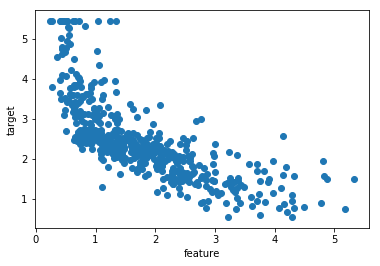

In [10]:
from sklearn.datasets import load_boston

X, Y = load_boston(return_X_y=True)
print(X.shape)
X = X[:, -1] / X[:, -1].std()
Y = Y / Y.std()

plt.figure()
plt.scatter(X, Y)
plt.ylabel("target")
plt.xlabel("feature")
plt.show()

Нужно провести прямую линию, минимизирующую MSE.
Запишем вычислительный граф и получим градиенты для одного шага градиентного спуска:

dL/dw = 
 tensor([-7.2240])
dL/db = 
 tensor([-4.9048])


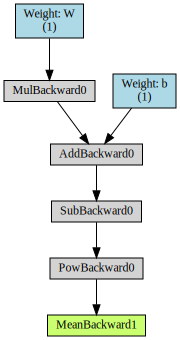

In [11]:
# model tensors
w = torch.zeros(1, requires_grad=True)
b = torch.zeros(1, requires_grad=True)

# data tensors
x = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(Y).type(torch.float)

y_pred = w * x + b
loss = torch.mean((y_pred - y)**2)

loss.backward()

#now w.grad is a tensor containing gradient of L w.r.t. w
print("dL/dw = \n", w.grad)
print("dL/db = \n", b.grad)


torchviz.make_dot(loss, {"Weight: W": w, "Weight: b": b})

Предлагается реализовать обучение модели линейной регрессии.

**(0.1 балла)** Напишите код для обновления весов:

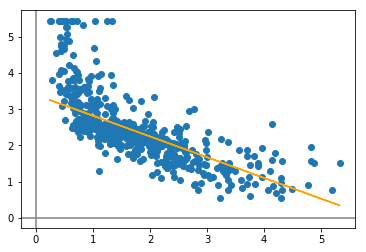

loss =  0.4884285628795624
Done!


In [12]:
import torch.optim as optim



x = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(Y).type(torch.float)

w = torch.zeros(1, requires_grad=True)
b = torch.zeros(1, requires_grad=True)

optimizer = optim.SGD([w,b], lr=0.1)

for i in range(100):    
    # напишите шаг градиентного спуска

    # zero gradients
    if i!=0:
        w.grad.zero_()
        b.grad.zero_()

    y_pred = w * x + b
    loss = torch.mean((y_pred - y)**2)
    
    loss.backward()
    optimizer.step()
    
    # the rest of code is just bells and whistles
    if (i + 1) % 5==0:
        #draw linear regression prediction vs data
        clear_output(True)
        plt.axhline(0, color='gray')
        plt.axvline(0, color='gray')
        plt.scatter(x.numpy(),y.numpy())
        plt.plot(x.numpy(),y_pred.data.numpy(),color='orange')
        plt.show()

        print("loss = ", loss.item())
        if loss.item() < 0.5:
            print("Done!")
            break

# Optimizers

В этом примере мы пользовались простым правилом для градиентного спуска:
  
$$\theta^{n+1} = \theta^{n} - \alpha \nabla_{\theta}L$$


Единственным параметром в нем является $\alpha$ -- это `learning_rate`.

На практике часто используют различные модификации (например _Momentum_):

$$\theta^{n+1} = \theta^{n} - U^{n}\\
U^{n} = \gamma U^{n-1} + \alpha \nabla_{\theta}(L)
$$

Хороший обзор алгоритмов оптимизации для сетей можно посмотреть [тут](http://ruder.io/optimizing-gradient-descent/).



Pytorch предоставляет практически все широкораспространненные оптимизаторы:    
http://pytorch.org/docs/master/optim.html




Оптимизаторы очень просто использовать:

- при создании оптимизатора требуется указать список переменных, с которыми он будет работать
- `opt.zero_grad()` сбрасывает градиенты
- `opt.step()` применяет `update` ($U^{n}$) к весам

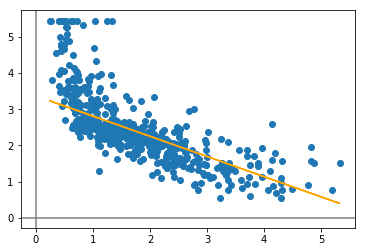

loss =  0.49351754784584045
Done!


In [13]:
# get data
x = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(Y).type(torch.float)
# model tensors
w = torch.zeros(1, requires_grad=True)
b = torch.zeros(1, requires_grad=True)

# define optimizer
opt = torch.optim.RMSprop([w, b], lr=0.1)

for i in range(100):
    # compute loss
    y_pred = w * x  + b
    loss = torch.mean((y_pred - y) ** 2)
    
    # backprop and gradient descent
    opt.zero_grad()
    loss.backward()
    opt.step()
    
    
    #the rest of code is just bells and whistles
    if (i + 1) % 5 == 0:
        #draw linear regression prediction vs data
        clear_output(True)
        plt.axhline(0, color='gray')
        plt.axvline(0, color='gray')
        plt.scatter(x.numpy(), y.numpy())
        plt.plot(x.numpy(), y_pred.data.numpy(), color='orange')
        plt.show()

        print("loss = ", loss.item())
        if loss.item() < 0.5:
            print("Done!")
            break

## Highlevel-API 

При работе с нейронными сетями становится неудобно контролировать переменные с весами по-отдельности. 
Pytorch предоставляет высокоуровневый API для моделей: [nn.Module](http://pytorch.org/docs/master/nn.html#torch.nn.Module)

Чтобы воспользоваться моделью необходимо отнаследоваться от `torch.nn.Module`, определить слои и описать `forward`. 

`backward` будет вычислен автоматически.

In [14]:
# Higher-level API:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, in_channels=784, hidden_size=40):
        super(Net, self).__init__()
        # here you construct weights for layers
        self.fc1 = nn.Linear(784, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 10)
        
    def forward(self, x):
        # here you describe usage of layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=-1)
    # backward function computes automaticaly


net = Net()
net(torch.rand(3, 784))

tensor([[-2.2611, -2.3984, -2.2750, -2.2701, -2.3886, -2.1373, -2.2063, -2.4126,
         -2.2338, -2.4978],
        [-2.2431, -2.4437, -2.2836, -2.2553, -2.3466, -2.1719, -2.1960, -2.4024,
         -2.1855, -2.5713],
        [-2.2476, -2.3913, -2.2110, -2.3100, -2.3467, -2.1941, -2.1825, -2.4267,
         -2.2098, -2.5767]], grad_fn=<LogSoftmaxBackward>)

Простую цепочку слоев удобно заворачивать в `nn.Sequential`.
В таком случае не придется писать `.forward`

In [15]:
net = nn.Sequential(
    nn.Linear(784, 40),
    nn.ReLU(),
    nn.Linear(40, 40),
    nn.ReLU(),
    nn.Linear(40, 10),
    nn.LogSoftmax(dim=1),
)
net(torch.rand(32, 784)).shape

torch.Size([32, 10])

В качестве датасета возьмем FashionMNIST

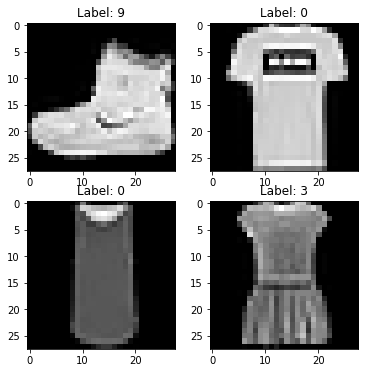

In [16]:
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST
from torchvision import transforms


default_transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Lambda(lambda t: t.reshape(-1))]  # let's convert image (28, 28) to vector (784)
)
train_dataset = FashionMNIST("./tmp", train=True, download=True, transform=default_transform)
test_dataset = FashionMNIST("./tmp", train=False, download=True, transform=default_transform)

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=32)
test_loader = DataLoader(test_dataset, shuffle=True, batch_size=32)

train_dataset[0][0].shape
plt.figure(figsize=[6, 6])
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.title("Label: %i" % train_dataset[i][1])
    plt.imshow(train_dataset[i][0].reshape(28, 28), cmap='gray')  # don't forget convert vector to image

In [17]:
for x,y in train_loader:
    print(x)
    print(y)
    break

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([0, 4, 4, 8, 0, 2, 5, 4, 3, 7, 4, 1, 3, 0, 1, 2, 5, 7, 9, 3, 7, 1, 5, 5,
        8, 7, 9, 7, 7, 6, 7, 4])


**(0.1 балла)** Напишите код для тренировки.
Предлагается для треккинга экспериментов использовать [`defaultdict`](https://docs.python.org/3.3/library/collections.html#defaultdict-objects)

**NB: обязательно доставайте числа из тензоров, не сохраняйте тензора с каждой итерации в какой-нибудь буффер.
Каждый тензор тащит за собой информацию для построения графа, это ест память**

In [18]:
# import pdb


#         images, labels = data
#         outputs = net(images)
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()



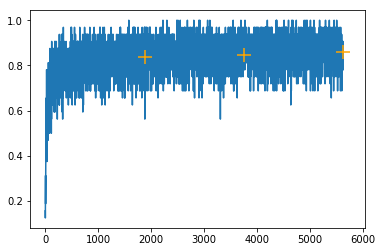

In [32]:
def train(model, optimizer, dataloader):
    model.train()
    loss_f = nn.CrossEntropyLoss()

    logs = defaultdict(list)
    for x, y in tqdm(dataloader):
        optimizer.zero_grad()
        y_pred = model(x)
        

        loss = loss_f(y_pred, y)
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(y_pred.data, 1)
        total = y.size(0)
        correct = (predicted==y).sum().item()
        acc = correct/total
        # у вас должно быть две скалярных переменных: с метрикой (acc) и лоссом (loss)
        logs['acc'].append(acc)
        logs['loss'].append(loss.item())
    return logs

def test(model, dataloader):
    model.eval()
    loss_f = nn.CrossEntropyLoss()

    logs = defaultdict(list)
    for x, y in tqdm(dataloader):

        y_pred = model(x)
        loss = loss_f(y_pred, y)
        _, predicted = torch.max(y_pred.data, 1)
        correct = (predicted==y).sum().item()
        
        acc = correct/y.shape[0]

        
        # у вас должно быть две скалярных переменных: с метрикой (acc) и лоссом (loss)
        logs['acc'].append(acc)
        logs['loss'].append(loss.item())
    
    return {k: [np.mean(v)] for k, v in logs.items()}


def plot_logs(logs):
    plt.figure()
    plt.plot(logs['acc'], zorder=1)
    plt.scatter(logs['steps'], logs['test_acc'], marker='+', s=180, c='orange', label='val', zorder=2)
    plt.show()


model = nn.Sequential(
    nn.Linear(784, 40),
    nn.ReLU(),
    nn.Linear(40, 40),
    nn.ReLU(),
    nn.Linear(40, 10),
    nn.LogSoftmax(dim=1),
)
opt = torch.optim.RMSprop(model.parameters(), lr=0.001)
    

# история всего обучения
logs = defaultdict(list)
for epoch in range(3):
    train_logs = train(model, opt, train_loader)
    
    # мерджим историю эпохи к истории обучения
    for k, v in train_logs.items():
        logs[k].extend(v)
        
    # метрики с валидации усредняем -- они относятся к одному состоянию весов 
    # сотояние весов определяется количеством тренировочных шагов

    
    test_logs = test(model, test_loader)
    for k, v in test_logs.items():
        logs[f'test_{k}'].extend(v)
    logs['steps'].append(len(logs['loss']))
    
    clear_output()
    plot_logs(logs)
    

In [36]:
d={}
d.update({'a':1, 'b':2})
d

{'a': 1, 'b': 2}

In [37]:
'123'[0].isdigit()

True

## Fine Tuning


Для многих прикладных задач не существует больших датасетов с хорошей разметкой. 
Поэтому распространенным приемом является тренировка на похожем, но большом датасете и доучивание сети на целевом.

Такой прием называют **Transfer Learning** или **Finetuning**.

В сверточных сетях для классификации выделяют две части:
- тело сети -- feature extractor, набор сверток и пулингов (convolutions and poolings)
- голову -- это MLP (набор полносвязных слоев) после которых делается softmax и получаются вероятности разных классов.


Вычислительно простым вариантом finetuning является обучение головы при замороженном feature extractor'е.

Нам потребуется [предобученная модель](http://pytorch.org/docs/master/torchvision/datasets.html#torchvision-datasets) и датасет для нашей задачи.

Предлагается воспользоваться моделью обученной на Imagenet, а в качестве целевого взять [Imagenette (это небольшое простое подмножество Imagenet)](https://github.com/fastai/imagenette)

Архив с картинками доступен на
https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-160.tgz

**Не запускайте на медленном канале! Весит ~95Mb**

In [19]:
! wget https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-160.tgz
! tar xf imagenette2-160.tgz

--2020-01-29 21:59:10--  https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-160.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.8.246
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.8.246|:443... connected.
^C


В файловой системе должны появиться папки:
```bash
$ tree --filelimit 10
├── imagenette2-160
│   ├── train
│   │   ├── n01440764 [963 entries exceeds filelimit, not opening dir]
│   │   ├── n02102040 [955 entries exceeds filelimit, not opening dir]
│   │   ├── n02979186 [993 entries exceeds filelimit, not opening dir]
│   │   ├── n03000684 [858 entries exceeds filelimit, not opening dir]
│   │   ├── n03028079 [941 entries exceeds filelimit, not opening dir]
│   │   ├── n03394916 [956 entries exceeds filelimit, not opening dir]
│   │   ├── n03417042 [961 entries exceeds filelimit, not opening dir]
│   │   ├── n03425413 [931 entries exceeds filelimit, not opening dir]
│   │   ├── n03445777 [951 entries exceeds filelimit, not opening dir]
│   │   └── n03888257 [960 entries exceeds filelimit, not opening dir]
│   └── val
│       ├── n01440764 [387 entries exceeds filelimit, not opening dir]
│       ├── n02102040 [395 entries exceeds filelimit, not opening dir]
│       ├── n02979186 [357 entries exceeds filelimit, not opening dir]
│       ├── n03000684 [386 entries exceeds filelimit, not opening dir]
│       ├── n03028079 [409 entries exceeds filelimit, not opening dir]
│       ├── n03394916 [394 entries exceeds filelimit, not opening dir]
│       ├── n03417042 [389 entries exceeds filelimit, not opening dir]
│       ├── n03425413 [419 entries exceeds filelimit, not opening dir]
│       ├── n03445777 [399 entries exceeds filelimit, not opening dir]
│       └── n03888257 [390 entries exceeds filelimit, not opening dir]
...
```

In [20]:
from torchvision.datasets import ImageFolder

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(160),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.CenterCrop(160),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = ImageFolder("./imagenette2-160/train/", transform=train_transform)
test_dataset = ImageFolder("./imagenette2-160/val/", transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

**(0.1 балла)** выведите несколько примеров из train_dataset с метками.

**NB: Обратите внимание на преобразования, которые мы делаем над картинками и предупреждения, которые выдает `plt.imshow`**

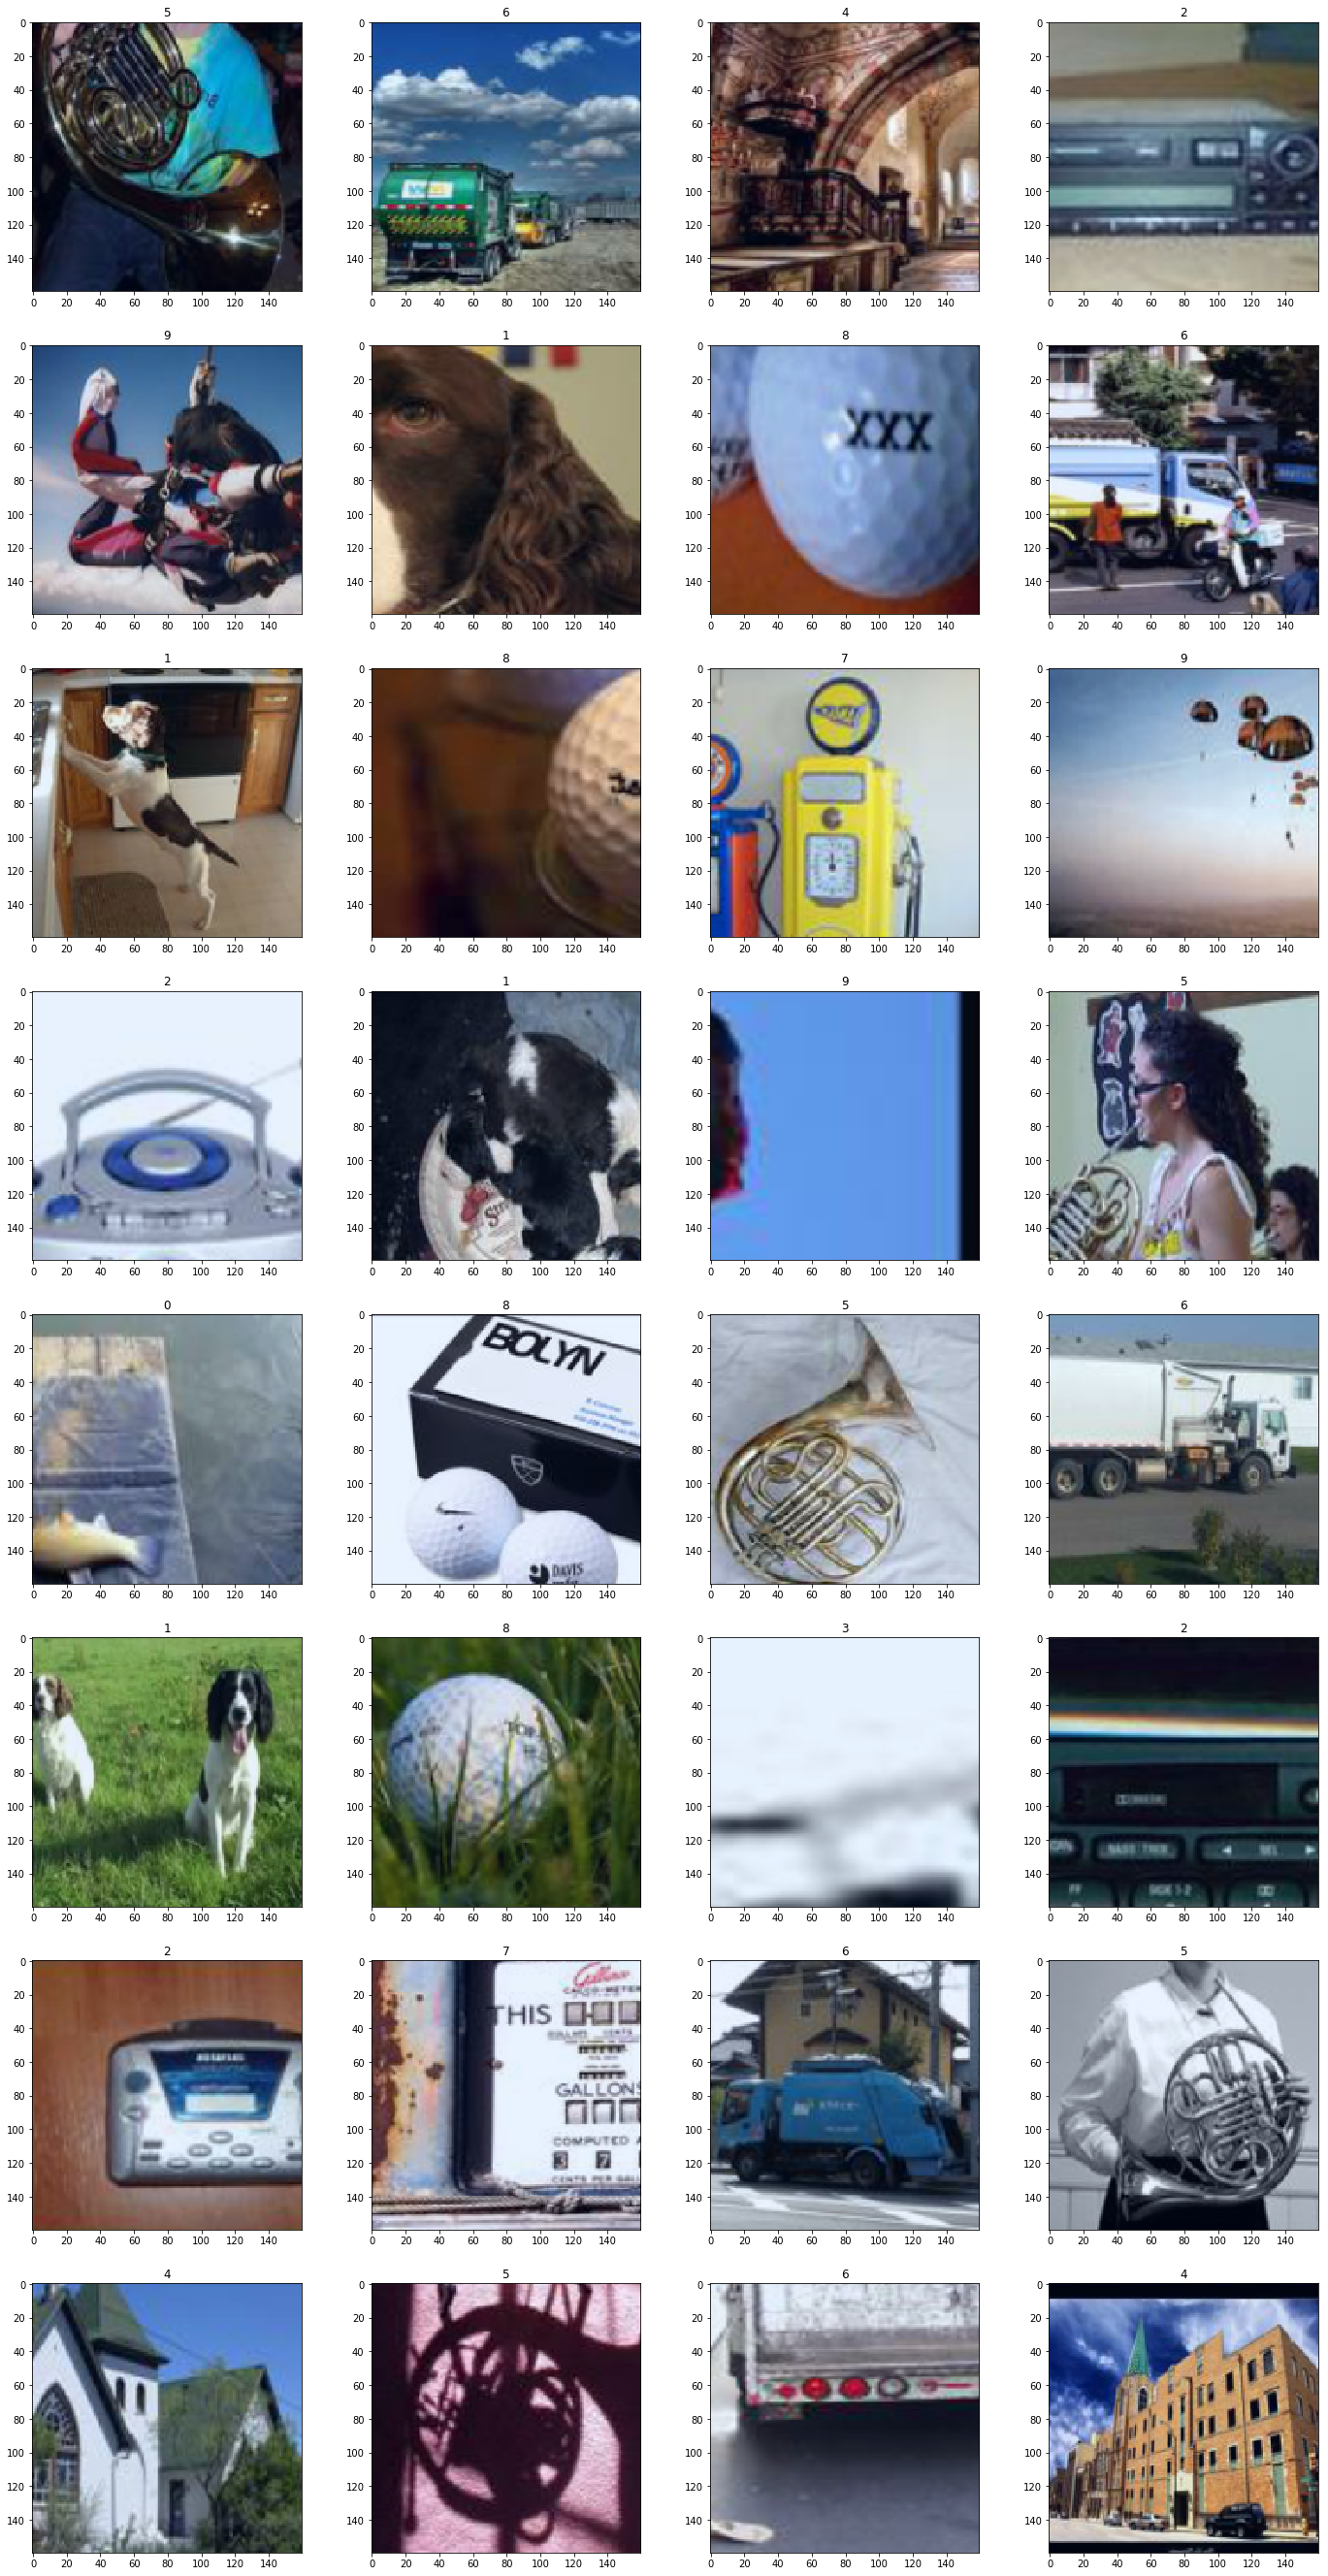

In [23]:
for x,y in train_loader:
    x_numpy = x.numpy()
    y_numpy = y.numpy()
    break
fig, ax = plt.subplots(nrows=8, ncols=4, figsize=(24,48))
for i in range(32):
    
    
    img = np.rollaxis(x_numpy[i], 0, 3)
    img1 = img-img.min()
    img2 = img1/img1.max()
    ax[i%8][i//8].imshow(img2)
    ax[i%8][i//8].set_title(y_numpy[i])
plt.show()

**(0.1 балла)** Модифицируйте модель так, чтобы она выдавала логиты на 10 классов, выберете для обучения только параметры измененного слоя.

In [26]:
from torchvision import models

model_ft = models.resnet18(pretrained=True)


print('Before: ', list(model_ft.named_modules())[-1])

model_ft.fc = nn.Linear(in_features=512, out_features=10)

print('After: ', list(model_ft.named_modules())[-1])

for params in model_ft.parameters():
    if 10 in params.shape:
        params.requires_grad = True 
    else:
        params.requires_grad = False 

    
params_to_train = [ x for x in model_ft.parameters() if 10 in x.shape]

optimizer = torch.optim.SGD(params_to_train, lr=0.001, momentum=0.9)

Before:  ('fc', Linear(in_features=512, out_features=1000, bias=True))
After:  ('fc', Linear(in_features=512, out_features=10, bias=True))


Чтобы воспользоваться GPU необходимо перенести модель и тензоры на устройство 'cuda'.
Это делается с помощью операции `.to`:
```
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
x = x.to(device)
y = y.to(device)
```

**Задания:**
- **(0.1 балла)** Модифицируйте тренировочный цикл так, чтобы вычисления производились на GPU.
- **(0.5 балла)** Проведите несколько экспериментов. В каком случае получается более высокое качество: при обучении всей сети или только последнего слоя? Почему?

In [27]:
torch.cuda.is_available()

True

In [ ]:
device='cpu'
# device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
x = x.to(device)
y = y.to(device)


def train(model, optimizer, dataloader):
    model.to(device)
    loss_f = nn.CrossEntropyLoss()

    model.train()
    logs = defaultdict(list)
    for x, y in tqdm(dataloader):
                
        
        y_pred = model(x)
        opt.zero_grad()
        loss = loss_f(y_pred, y)
        loss.backward()
        opt.step()
        correct = (y_pred.max(dim=1)[1]==y).sum().item()
        
        acc = correct/y.shape[0]

        
        
        logs['acc'].append(acc)
        logs['loss'].append(loss.item())
    return logs

def test(model, dataloader):
    loss_f = nn.CrossEntropyLoss()

    model.to(device)
    model.eval()
    logs = defaultdict(list)
    for x, y in tqdm(dataloader):
        
        y_pred = model_ft(x)
        opt.zero_grad()
        loss = loss_f(y_pred, y)
#         loss.backward()
#         opt.step()
        correct = (y_pred.max(dim=1)[1]==y).sum().item()
        
        acc = correct/y.shape[0]

        logs['acc'].append(acc)
        logs['loss'].append(loss.item())
    
    return {k: [np.mean(v)] for k, v in logs.items()}

def plot_logs(logs):
    plt.figure()
    plt.plot(logs['acc'], zorder=1)
    plt.scatter(logs['steps'], logs['test_acc'], marker='+', s=180, c='orange', label='val', zorder=2)
    plt.show()

logs = defaultdict(list)
for epoch in range(3):
    train_logs = train(model_ft, optimizer, train_loader)
    for k, v in train_logs.items():
        logs[k].extend(v)
        
    test_logs = test(model_ft, test_loader)
    for k, v in test_logs.items():
        logs[f'test_{k}'].extend(v)
    logs['steps'].append(len(logs['loss']))
    
    clear_output()
    plot_logs(logs)